In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd
import numpy as np
import math
from decimal import Decimal

#Read files

In [13]:
import os
import sys
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, save_npz, load_npz, vstack, hstack, lil_matrix
#import implicit
import pickle
#from implicit.evaluation import train_test_split, precision_at_k, mean_average_precision_at_k

def load_data():
    '''load the MovieLens 1m dataset in a Pandas dataframe'''
    ratings = pd.read_csv('/content/drive/MyDrive/ml-1m/ratings.dat', delimiter='::', header=None,
        names=['user_id', 'movie_id', 'rating', 'timestamp'],
        usecols=['user_id', 'movie_id', 'rating'], engine='python')

    return ratings


In [14]:
def load_movies_data():
    '''load the MovieLens 1m dataset in a Pandas dataframe'''
    movies = pd.read_csv('/content/drive/MyDrive/ml-1m/movies.dat', delimiter='::', header=None,
        names=['movie_id','title','genres'],
        usecols=['movie_id','title','genres'], engine='python',encoding='latin-1')

    return movies

In [15]:
ratings = load_data()
ratings

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [16]:
movies = load_movies_data()
movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


#QR Decompositon

In [17]:
def vector_norm(x):
    """Compute the L2 norm of a vector."""
    return Decimal(np.dot(x, x)).sqrt()

def qr_decomposition(A):
    """
    Compute the QR decomposition of a matrix A using the Gram-Schmidt algorithm.

    Parameters:
    A (numpy.ndarray): The matrix to decompose.

    Returns:
    (numpy.ndarray, numpy.ndarray): A tuple of Q and R matrices that represent the QR decomposition of A, where:
        Q (numpy.ndarray): The orthogonal matrix Q.
        R (numpy.ndarray): The upper triangular matrix R.
    """
    # Get the shape of the input matrix
    m, n = A.shape

    # Initialize the matrices
    Q = np.zeros((m, n))
    R = np.zeros((n, n))

    # Perform the Gram-Schmidt orthogonalization
    for j in range(n):
        v = A[:, j]
        for i in range(j):
            R[i, j] = np.dot(Q[:, i], A[:, j])
            v = v - R[i, j] * Q[:, i]
        # R[j, j] = np.linalg.norm(v)
        R[j, j] = vector_norm(v)
        Q[:, j] = v / R[j, j]

    return Q, R

#Rank

In [18]:
def rank_of_matrix(mat):
    """
    This function calculates the rank of a matrix 'mat' using Gaussian elimination method.
    It returns the rank of the matrix.
    """
    # Define the dimensions of the matrix
    m = len(mat)
    n = len(mat[0])

    rank = min(m, n)

    # Perform Gaussian elimination
    for row in range(rank):
        # Check if the diagonal element is not zero
        if mat[row][row] != 0:
            for col in range(row + 1, m):
                # Calculate the factor by which to multiply the current row
                # to eliminate the non-zero element in the current column
                factor = mat[col][row] / mat[row][row]
                for i in range(row, n):
                    # Update the current row by subtracting the product of the factor
                    # and the corresponding element in the row being eliminated from it
                    mat[col][i] -= factor * mat[row][i]
        else:
            # If the diagonal element is zero, look for a non-zero element below it
            # and swap the rows if necessary
            reduce_rank = True
            for i in range(row + 1, m):
                if mat[i][row] != 0:
                    mat[row], mat[i] = mat[i], mat[row]
                    reduce_rank = False
                    break
            if reduce_rank:
                rank -= 1
                for i in range(row, m):
                    mat[i][row] = mat[i][rank]

    return rank


#Finding eigen values and vectors

In [19]:
def eig(A):
    """
    Compute the eigenvalues and eigenvectors of a matrix A using the power iteration method.

    Parameters:
    A (numpy.ndarray): The matrix to compute eigenvalues and eigenvectors.

    Returns:
    (eigvals, eigvecs): A tuple of arrays that represent the eigenvalues and eigenvectors of A, where:
        eigvals (numpy.ndarray): The eigenvalues of A.
        eigvecs (numpy.ndarray): The eigenvectors of A.
    """
    # set the number of iterations and tolerance level
    max_iter = 100
    tol = 1e-6

    # initialize the eigenvectors
    m, n = A.shape
    eigvecs = np.random.randn(n, n)

    # compute the largest eigenvalue and eigenvector
    for i in range(max_iter):
        # compute the new eigenvector
        eigvecs_new = A @ eigvecs
        # eigvecs_new, _ = np.linalg.qr(eigvecs_new)
        eigvecs_new, _ = qr_decomposition(eigvecs_new)
        if np.allclose(eigvecs_new, eigvecs, rtol=tol):
            break
        eigvecs = eigvecs_new

    # compute the eigenvalues
    eigvals = np.diag(eigvecs.T @ A @ eigvecs)

    return eigvals, eigvecs

#SVD

In [20]:
def SVD(A):
    """
    Compute Singular Value Decomposition of matrix A using NumPy.

    Args:
        A: numpy.array, matrix to be decomposed

    Returns:
        U: numpy.array, matrix containing left singular vectors
        s: numpy.array, array containing singular values
        V_T: numpy.array, matrix containing right singular vectors (transposed)
    """
    # Compute the eigenvectors and eigenvalues of A*At or At*A, whichever is smaller
    if A.shape[0] < A.shape[1]:
        # S = np.dot(A, A.T)
        S = A @ A.T
        # print(A @ A.T)
        # k = np.linalg.matrix_rank(S)
        k = rank_of_matrix(S.copy())
    else:
        # S = np.dot(A.T, A)
        S = A.T @ A
        # k = np.linalg.matrix_rank(S)
        k = rank_of_matrix(S.copy())

    # eigvals, eigvecs = np.linalg.eig(S) #NOT ALLOWED
    # print(S)
    eigvals, eigvecs = eig(S)
    # print(eigvals)
    # Sort the eigenvectors by descending eigenvalues
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:,sorted_indices]

    # Compute the singular values and their reciprocals
    s = np.sqrt(eigvals)
    # s = s[s > 10e-6]
    s = s[:k]
    s_inv = np.zeros_like(A.T)
    np.fill_diagonal(s_inv, 1.0 / s)

    # Compute the left and right singular vectors
    # if(A.shape[0] > A.shape[1]):
    if(A.shape[0] > A.shape[1]):
        U = np.dot(A, np.dot(eigvecs, s_inv))
        V_T = eigvecs.T
        if(len(s) != V_T.shape[0]): V_T = V_T[:len(s) - V_T.shape[0], :]

    else:
        U = eigvecs
        V_T = np.dot(s_inv, np.dot(U.T, A))
        if(len(s) != U.shape[1]): U = U[:, :len(s) - U.shape[1]]



    # else:
    #     V_T = np.dot(s_inv, np.dot(eigvecs, A))
    #     U = eigvecs.T
    #     if(len(s) != V_T.shape[0]): V_T = V_T[:len(s) - V_T.shape[0], :]

    sigma = np.zeros([U.shape[1], V_T.shape[0]])
    # sigma = np.zeros([len(s), len(s)])
    # sigma = np.diag(s)
    # if(A.shape[0] < A.shape[1]):
    for i in range(len(s)):
        sigma[i, i] = s[i]
    # else:
    #     for i in range(len(s)):
    #         sigma[i, i] = s[i]

    return U, s, sigma, V_T

In [21]:
def ReducedSVD(A, threshold = 0, to_remove = 0):
    U, s, sigma, V_trans = SVD(A)

    # While converting to python code we will convert into GUI asking-
    #       - Removal based on:-
    #       - 1. Hyper parameter
    #       - 2. Threshold
    print(s)

    # Removal based on hyper parameter
    if(to_remove < len(s) and to_remove > 0):
        s = s[:-to_remove]
        print(s)
        U = U[:, :-to_remove]
        V_trans = V_trans[:-to_remove, :]
        sigma = sigma[:-to_remove, :-to_remove]

    elif(to_remove < 0):
        print("The number of eigen values to be romved is Invalid!!")
        exit()

    # Removal based on threshold
    if(threshold < s[0] and threshold > 0):
        s = s[s >= threshold]
        print(s)
        U = U[:, :len(s)]
        V_trans = V_trans[:len(s), :]
        sigma = sigma[:len(s), :len(s)]

    elif(threshold < 0):
        print("Invalid threshold value!!")
        exit()

    return U, s, sigma, V_trans

In [22]:
import numpy as np
from scipy.spatial import distance

class KMeans:
    def __init__(self, K, iter_count, p):
        self.K = K
        self.iter_count = iter_count
        self.p = p
        self.clusters = [[] for _ in range(self.K)]  # Initializing empty clusters to store indices
        self.centroids = []  # Storing centroids
        self.inertia = 0.0  # Inertia value

    def k_means_plus_plus(self, dataset: np.array, k, random_state=1000):
        """
        Create cluster centroids using the k-means++ algorithm.
        Parameters
        ----------
        dataset : numpy array
            The dataset to be used for centroid initialization.
        k : int
            The desired number of clusters for which centroids are required.
        Returns
        -------
        centroids : numpy array
            Collection of k centroids as a numpy array.
        """
        np.random.seed(random_state)
        centroids = [dataset[0]]

        for _ in range(1, k):
            dist_sq = np.array([min([np.inner(c-x, c-x) for c in centroids]) for x in dataset])
            probs = dist_sq / dist_sq.sum()
            cumulative_probs = probs.cumsum()
            r = np.random.rand()

            for j, p in enumerate(cumulative_probs):
                if r < p:
                    i = j
                    break

            centroids.append(dataset[i])

        return np.array(centroids)

    def predict(self, X, choice=0):
        self.X = X
        self.n_samples, self.n_features = X.shape

        # Initialize centroids
        if choice == 0:
            centroids = np.zeros((self.K, self.n_features))
            for k in range(self.K):
                centroid = X[np.random.choice(range(self.n_samples))]
                centroids[k] = centroid
            self.centroids = centroids
        elif choice == 1:
            self.centroids = self.k_means_plus_plus(X, self.K)

        for _ in range(self.iter_count):
            self.clusters = self._create_clusters(self.centroids)
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)
            if self._is_converged(centroids_old, self.centroids):
                break

        labels = self.get_cluster_labels(self.clusters)
        self.calculate_inertia(X, labels)
        return labels

    def _create_clusters(self, centroids):
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    def _closest_centroid(self, sample, centroids):
        distances = [distance.minkowski(sample, point, self.p) for point in centroids]
        # print("Distance array is")
        # print(distances)
        closest_idx = np.argmin(distances)
        return closest_idx

    def _get_centroids(self, clusters):
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            if len(cluster) != 0:
                cluster_mean = np.mean(self.X[cluster], axis=0)
                centroids[cluster_idx] = cluster_mean
        return centroids

    def _is_converged(self, centroids_old, centroids):
        distances = [distance.minkowski(centroids_old[i], centroids[i], self.p) for i in range(self.K)]
        return sum(distances) == 0

    def get_cluster_labels(self, clusters):
        labels = np.empty(self.n_samples)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                labels[sample_idx] = cluster_idx
        return labels

    def calculate_inertia(self, datapoints, labels):
        labels = labels.astype(int)
        for idx, pts in enumerate(datapoints):
            self.inertia += distance.minkowski(self.centroids[labels[idx]], pts, 2) ** 2

    def predict_point(self, datapoint):
        # print(self.centroids[0].shape)
        return self._closest_centroid(datapoint, self.centroids)

User genre matrix

In [23]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
movies

,movie_id,title,genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
3878,3948,Meet the Parents (2000),[Comedy]
3879,3949,Requiem for a Dream (2000),[Drama]
3880,3950,Tigerland (2000),[Drama]
3881,3951,Two Family House (2000),[Drama]


In [24]:
# Merge ratings and expanded movies DataFrames
merged_data = pd.merge(ratings, movies, on='movie_id',how='inner')
merged_data

,user_id,movie_id,rating,title,genres
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),[Drama]
1,2,1193,5,One Flew Over the Cuckoo's Nest (1975),[Drama]
2,12,1193,4,One Flew Over the Cuckoo's Nest (1975),[Drama]
3,15,1193,4,One Flew Over the Cuckoo's Nest (1975),[Drama]
4,17,1193,5,One Flew Over the Cuckoo's Nest (1975),[Drama]
...,...,...,...,...,...
1000204,5949,2198,5,Modulations (1998),[Documentary]
1000205,5675,2703,3,Broken Vessels (1998),[Drama]
1000206,5780,2845,1,White Boys (1999),[Drama]
1000207,5851,3607,5,One Little Indian (1973),"[Comedy, Drama, Western]"


In [25]:
exploded_data = merged_data.explode('genres')

In [26]:
exploded_data

,user_id,movie_id,rating,title,genres
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...
1000206,5780,2845,1,White Boys (1999),Drama
1000207,5851,3607,5,One Little Indian (1973),Comedy
1000207,5851,3607,5,One Little Indian (1973),Drama
1000207,5851,3607,5,One Little Indian (1973),Western


In [27]:
pivot_table = pd.pivot_table(exploded_data, values='rating', index='user_id', columns='genres', aggfunc=np.mean)
pivot_table[np.isnan(pivot_table)] = 2.5
pivot_table.isna().sum()

genres
Action         0
Adventure      0
Animation      0
Children's     0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
dtype: int64

In [28]:
pivot_table

genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,
1,4.200000,4.000000,4.111111,4.250000,4.142857,4.000000,2.500000,4.428571,4.00,2.500000,2.500000,4.285714,2.500000,3.666667,4.333333,3.666667,5.000000,2.500000
2,3.500000,3.736842,2.500000,2.500000,3.560000,3.583333,2.500000,3.898734,3.00,4.000000,3.000000,2.500000,3.333333,3.708333,3.588235,3.483871,3.733333,4.333333
3,3.956522,4.000000,4.000000,4.000000,3.766667,2.500000,2.500000,4.000000,4.50,2.500000,2.666667,4.000000,3.000000,3.800000,3.833333,3.800000,4.000000,4.666667
4,4.157895,3.833333,2.500000,4.000000,2.500000,5.000000,2.500000,4.166667,4.50,2.500000,4.333333,2.500000,2.500000,4.000000,3.555556,3.500000,3.333333,4.500000
5,2.612903,3.000000,4.000000,3.833333,3.410714,3.285714,3.666667,3.096154,2.50,4.000000,2.800000,3.333333,3.125000,3.100000,3.066667,2.846154,3.500000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,3.000000,2.987952,3.911765,3.444444,3.203065,3.528302,3.909091,3.505376,3.00,4.058824,2.986486,3.709677,3.411765,3.352459,2.834320,3.142857,3.785714,3.642857
6037,3.642857,4.000000,4.000000,3.666667,3.576271,3.833333,4.000000,3.877551,4.25,3.444444,4.111111,4.000000,3.692308,3.681818,3.692308,3.705882,4.000000,3.750000
6038,3.000000,4.000000,3.666667,3.000000,3.833333,2.500000,2.500000,3.888889,2.50,2.500000,2.500000,2.500000,2.500000,4.166667,4.000000,2.500000,4.000000,2.500000


In [29]:
pivot_table_standardized = (pivot_table - np.mean(pivot_table, axis=0)) / np.std(pivot_table, axis=0)

In [30]:
pivot_table = pivot_table_standardized

In [31]:
U,s,sigma,V_t = SVD(np.array(pivot_table))

In [32]:
U @ sigma @ V_t

array([[ 1.0343862 ,  0.66362961,  0.77535269, ..., -0.03985385,
         1.61888184, -0.84705883],
       [-0.18381329,  0.26313847, -1.11931754, ..., -0.35585953,
        -0.22473885,  1.18380321],
       [ 0.61066464,  0.66362961,  0.64468578, ...,  0.19064441,
         0.16339182,  1.55305085],
       ...,
       [-1.05395579,  0.66362961,  0.25268504, ..., -2.05671362,
         0.16339182, -0.84705883],
       [ 0.6863292 ,  0.81581624,  0.19237723, ...,  0.78335422,
         0.32511293,  1.36842703],
       [-1.09539115, -1.13493968, -0.53131644, ...,  0.40989885,
        -0.2795834 ,  0.81455556]])

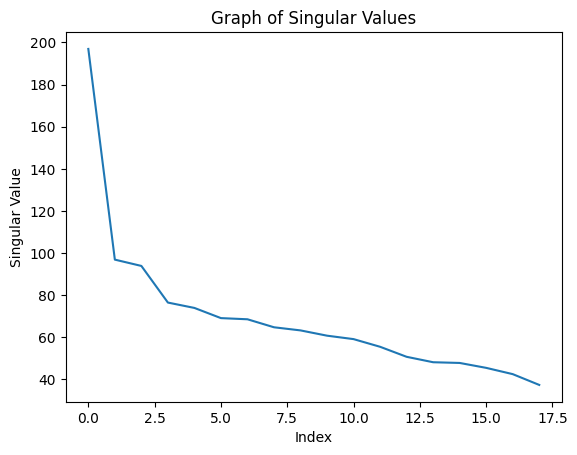

In [33]:
# prompt: plot the graph of valeus of s

import matplotlib.pyplot as plt

plt.plot(s)
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Graph of Singular Values')
plt.show()


In [34]:
non_zero_columns = np.nonzero(sigma.any(axis=0))[0]
non_zero_columns

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [35]:
s = np.sort(s)
s = s[::-1]
s

array([196.93839305,  96.8902317 ,  93.89373747,  76.50139066,
        73.95244753,  69.11857439,  68.5640704 ,  64.76692788,
        63.28228515,  60.77825584,  59.14516144,  55.50461102,
        50.74711989,  48.16851006,  47.82850035,  45.49588518,
        42.52087185,  37.39558873])

Trying k means

In [36]:
pivot_table

genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,
1,1.034386,0.663630,0.775353,1.033601,0.995491,0.434096,-0.580704,1.283735,0.750899,-1.103591,-0.889215,0.991734,-1.291828,-0.029417,1.246946,-0.039854,1.618882,-0.847059
2,-0.183813,0.263138,-1.119318,-1.090669,-0.150392,-0.149359,-0.580704,0.122422,-0.434492,0.489610,-0.278720,-1.080239,-0.270595,0.042175,0.101863,-0.355860,-0.224739,1.183803
3,0.610665,0.663630,0.644686,0.730134,0.255910,-1.666341,-0.580704,0.344379,1.343595,-1.103591,-0.685717,0.660219,-0.679088,0.199675,0.478535,0.190644,0.163392,1.553051
4,0.961111,0.409985,-1.119318,0.730134,-2.234326,1.834388,-0.580704,0.709684,1.343595,-1.103591,1.349265,-1.080239,-1.291828,0.543313,0.051640,-0.327977,-0.806935,1.368427
5,-1.727614,-0.858237,0.644686,0.527823,-0.443884,-0.566112,0.770930,-1.636699,-1.027187,0.489610,-0.522918,-0.113318,-0.525903,-1.003057,-0.699695,-1.458305,-0.564353,0.814556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,-1.053956,-0.876572,0.540921,0.055763,-0.852117,-0.226419,1.051789,-0.739753,-0.434492,0.552089,-0.295220,0.323356,-0.174479,-0.569285,-1.056771,-0.945383,-0.148499,0.418933
6037,0.064799,0.663630,0.644686,0.325511,-0.118403,0.200714,1.157111,0.075992,1.047247,-0.100464,1.077934,0.660219,0.169321,-0.003383,0.261804,0.027940,0.163392,0.537620
6038,-1.053956,0.663630,0.252685,-0.483735,0.386975,-1.666341,-0.580704,0.100842,-1.027187,-1.103591,-0.889215,-1.080239,-1.291828,0.829678,0.734672,-2.056714,0.163392,-0.847059


In [69]:
kmeanModel = KMeans(55,100,2)
pred = kmeanModel.predict(np.array(U[:,:18]),1)
pred

array([ 0., 43., 50., ..., 14., 42., 45.])

In [70]:
unique_values, counts = np.unique(pred, return_counts=True)

# Print unique values and their occurrences
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Occurrence: {count}")

Value: 0.0, Occurrence: 107
Value: 1.0, Occurrence: 162
Value: 2.0, Occurrence: 34
Value: 3.0, Occurrence: 79
Value: 4.0, Occurrence: 62
Value: 5.0, Occurrence: 75
Value: 6.0, Occurrence: 15
Value: 7.0, Occurrence: 188
Value: 8.0, Occurrence: 37
Value: 9.0, Occurrence: 122
Value: 10.0, Occurrence: 57
Value: 11.0, Occurrence: 166
Value: 12.0, Occurrence: 73
Value: 13.0, Occurrence: 89
Value: 14.0, Occurrence: 69
Value: 15.0, Occurrence: 137
Value: 16.0, Occurrence: 113
Value: 17.0, Occurrence: 146
Value: 18.0, Occurrence: 61
Value: 19.0, Occurrence: 118
Value: 20.0, Occurrence: 46
Value: 21.0, Occurrence: 317
Value: 22.0, Occurrence: 147
Value: 23.0, Occurrence: 146
Value: 24.0, Occurrence: 24
Value: 25.0, Occurrence: 126
Value: 26.0, Occurrence: 45
Value: 27.0, Occurrence: 82
Value: 28.0, Occurrence: 57
Value: 29.0, Occurrence: 86
Value: 30.0, Occurrence: 48
Value: 31.0, Occurrence: 19
Value: 32.0, Occurrence: 30
Value: 33.0, Occurrence: 58
Value: 34.0, Occurrence: 81
Value: 35.0, Occu

Value: 0.0, Occurrence: 107
Value: 1.0, Occurrence: 162
Value: 2.0, Occurrence: 34
Value: 3.0, Occurrence: 79
Value: 4.0, Occurrence: 62
Value: 5.0, Occurrence: 75
Value: 6.0, Occurrence: 15
Value: 7.0, Occurrence: 188
Value: 8.0, Occurrence: 37
Value: 9.0, Occurrence: 122
Value: 10.0, Occurrence: 57
Value: 11.0, Occurrence: 166
Value: 12.0, Occurrence: 73
Value: 13.0, Occurrence: 89
Value: 14.0, Occurrence: 69
Value: 15.0, Occurrence: 137
Value: 16.0, Occurrence: 113
Value: 17.0, Occurrence: 146
Value: 18.0, Occurrence: 61
Value: 19.0, Occurrence: 118
Value: 20.0, Occurrence: 46
Value: 21.0, Occurrence: 317
Value: 22.0, Occurrence: 147
Value: 23.0, Occurrence: 146
Value: 24.0, Occurrence: 24
Value: 25.0, Occurrence: 126
Value: 26.0, Occurrence: 45
Value: 27.0, Occurrence: 82
Value: 28.0, Occurrence: 57
Value: 29.0, Occurrence: 86
Value: 30.0, Occurrence: 48
Value: 31.0, Occurrence: 19
Value: 32.0, Occurrence: 30
Value: 33.0, Occurrence: 58
Value: 34.0, Occurrence: 81
Value: 35.0, Occu

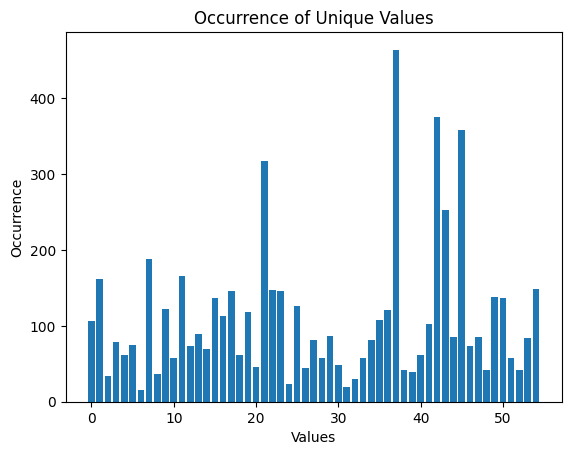

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
# pred = np.array([0, 1, 2, 2, 1, 0, 2, 0, 1, 2])

# Get unique values and their occurrences
unique_values, counts = np.unique(pred, return_counts=True)

# Print unique values and their occurrences
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Occurrence: {count}")

# Create a bar plot
plt.bar(unique_values, counts)
plt.xlabel("Values")
plt.ylabel("Occurrence")
plt.title("Occurrence of Unique Values")
plt.show()

In [39]:
user_ratings = pivot_table.iloc[2]
user_ratings

genres
Action         0.610665
Adventure      0.663630
Animation      0.644686
Children's     0.730134
Comedy         0.255910
Crime         -1.666341
Documentary   -0.580704
Drama          0.344379
Fantasy        1.343595
Film-Noir     -1.103591
Horror        -0.685717
Musical        0.660219
Mystery       -0.679088
Romance        0.199675
Sci-Fi         0.478535
Thriller       0.190644
War            0.163392
Western        1.553051
Name: 3, dtype: float64

In [40]:
kmeanModel.centroids

array([[ 2.75021778e-03, -5.29873289e-03,  1.27212590e-02,
        -9.05983030e-03,  1.67257109e-03,  6.57433164e-03,
        -3.32671113e-03,  4.39535849e-03, -7.00111901e-03,
         1.57925435e-02, -1.07235897e-02,  8.55212407e-03,
        -9.75774325e-03,  4.44154464e-04,  4.55491242e-03,
        -4.20039840e-03, -4.84184297e-03, -6.13472727e-04],
       [-8.86247163e-03,  1.01291499e-02, -2.54486879e-03,
        -1.66387781e-04,  7.39363137e-04,  2.33123857e-02,
         9.80168488e-03, -2.77680249e-03,  5.15467369e-03,
         2.64326691e-03,  3.13711875e-04,  2.82811918e-03,
        -1.34315533e-03, -4.54449765e-03, -1.29027702e-03,
        -9.77541488e-04,  4.17210150e-03,  1.26416619e-03],
       [ 9.64234797e-03, -7.78622696e-03,  5.98546457e-03,
         8.32833511e-03,  1.93159548e-03,  1.25782947e-02,
        -2.25677712e-02, -6.40171792e-03,  6.81883921e-03,
         6.92969340e-03,  9.28718040e-03, -3.80273635e-03,
         2.07999914e-02,  2.43096371e-02,  2.33289459e

Finding cluster of user

In [41]:
unique_values = np.unique(sigma)
unique_values

array([  0.        ,  37.39558873,  42.52087185,  45.49588518,
        47.82850035,  48.16851006,  50.74711989,  55.50461102,
        59.14516144,  60.77825584,  63.28228515,  64.76692788,
        68.5640704 ,  69.11857439,  73.95244753,  76.50139066,
        93.89373747,  96.8902317 , 196.93839305])

In [42]:
user_vector = U[0,:18]
# user_vector = np.array(U)
# pivot_table.iloc[0]
print(user_vector)
user_vector.shape

[-1.00101647e-02 -1.09779579e-02  2.53842520e-02 -1.58280268e-02
  2.06726780e-03  8.54760488e-03  9.63347092e-03  1.65981812e-03
 -1.11168616e-02  2.02055813e-02 -1.96381389e-03  1.19980408e-02
  1.31170311e-02  1.29743789e-03  1.53454902e-02 -3.52862303e-03
 -8.31890606e-05  2.47682466e-03]


(18,)

In [43]:
prediction = kmeanModel.predict_point(user_vector)
prediction
# print(kmeanModel.centroids)
# print(np.array(user_ratings))

0

In [44]:
cluster = kmeanModel.clusters[prediction]

In [45]:
filtered_ratings = ratings[(ratings['user_id'].isin(cluster))]
filtered_ratings

,user_id,movie_id,rating
6448,46,3280,5
6449,46,2628,1
6450,46,3939,5
6451,46,1327,5
6452,46,3361,1
...,...,...,...
988632,5966,1089,4
988633,5966,1094,3
988634,5966,1095,5
988635,5966,562,1


In [46]:
movie_ratings_sum = filtered_ratings.groupby('movie_id')['rating'].mean()
# movie_counts = filtered_ratings['movie_id'].value_counts()
# average_ratings = movie_ratings_sum / movie_counts
# average_ratings
result_df = movie_ratings_sum.reset_index()
result_df

,movie_id,rating
0,1,4.090909
1,2,2.900000
2,3,3.444444
3,4,2.000000
4,5,2.600000
...,...,...
2526,3947,3.500000
2527,3948,3.650000
2528,3949,3.750000
2529,3950,2.000000


In [47]:
movie_counts = filtered_ratings.groupby('movie_id')['rating'].count()
movie_counts = movie_counts.reset_index()
movie_counts

,movie_id,rating
0,1,33
1,2,10
2,3,9
3,4,1
4,5,5
...,...,...
2526,3947,2
2527,3948,20
2528,3949,8
2529,3950,1


In [48]:
df1 = np.log(len(kmeanModel.clusters[prediction])/movie_counts['rating'])
print(len(kmeanModel.clusters[prediction]))
df1

107


0       1.176321
1       2.370244
2       2.475604
3       4.672829
4       3.063391
          ...   
2526    3.979682
2527    1.677097
2528    2.593387
2529    4.672829
2530    3.063391
Name: rating, Length: 2531, dtype: float64

In [49]:
result_df['rating'] = result_df['rating'] * df1
result_df['rating'] /= sum(df1)
result_df.sort_values(by='rating').head()['movie_id']

1847    2858
1790    2762
762     1210
1703    2628
749     1196
Name: movie_id, dtype: int64

In [50]:
asalu = ratings[(ratings['user_id'] == 1) & (ratings['movie_id'] == 2028)]
asalu

,user_id,movie_id,rating
48,1,2028,5


In [51]:
import numpy as np
import pandas as pd
import random

def find_mse(kmeanModel, U, ratings):
    mean_squared_diffs = []
    user_ids_range = random.sample(range(1, 6041), 50)

    for user_id in user_ids_range:
        # Predict the cluster for the user
        prediction = kmeanModel.predict_point(U[user_id-1,:18])
        cluster = kmeanModel.clusters[prediction]

        # Filter ratings for movies watched by the user and movies in the predicted cluster
        filtered_ratings = ratings[ratings['user_id'].isin(cluster)]

        # Calculate the average rating for movies in the filtered ratings
        predicted_rating = pd.DataFrame(filtered_ratings.groupby('movie_id')['rating'].mean())
        predicted_rating = predicted_rating.rename(columns={'rating': 'predicted_rating'}).reset_index()

        p_m_id = np.array(predicted_rating['movie_id'])
        n_m_id = np.array(ratings[ratings['user_id'] == user_id]['movie_id'])

        # Intersection of movies watched by the user and the cluster to which he belongs to
        intersection_movies = np.intersect1d(p_m_id, n_m_id)

        if len(intersection_movies) == 0:  # Avoid division by zero
            continue

        s = 0
        for i in intersection_movies:
            actual_rating = ratings[(ratings['user_id'] == user_id) & (ratings['movie_id'] == i)]['rating'].iloc[0]
            pred_rating = predicted_rating[predicted_rating['movie_id'] == i]['predicted_rating'].iloc[0]
            s += (actual_rating - pred_rating) ** 2

        # Calculate mean squared difference between actual and predicted ratings
        mean_squared_diff = s / len(intersection_movies)
        mean_squared_diffs.append(mean_squared_diff)

    return mean_squared_diffs

# Example usage (assuming kmeanModel, U, and ratings are defined):
# mse_results = find_mse(kmeanModel, U, ratings)
# print("Mean Squared Errors for each user:", mse_results)


In [52]:
mae = []
def find_eigen_values(pivot_table,ratings):
  kmeanModel = KMeans(55,100,2)
  for i in range(0,5):
    U,s,sigma,V_t = ReducedSVD(np.array(pivot_table),to_remove=i)
    pred = kmeanModel.predict(np.array(U[:,:18]),1)
    a = find_mse(kmeanModel,U,ratings)
    mae.append(a)
  return mae

In [53]:
user_ids_range = random.sample(range(1, 6041), 100)
user_ids_range

[2723,
 3745,
 5200,
 4162,
 122,
 1173,
 1365,
 4817,
 412,
 1286,
 5044,
 792,
 5811,
 2914,
 3453,
 2380,
 3438,
 3687,
 3751,
 5663,
 3055,
 4907,
 1406,
 3254,
 1225,
 4975,
 918,
 2488,
 2972,
 632,
 3432,
 1441,
 4900,
 949,
 5272,
 5548,
 1116,
 5845,
 2163,
 4581,
 3807,
 3842,
 955,
 4868,
 1684,
 4744,
 4039,
 1987,
 3808,
 4134,
 2314,
 5885,
 4569,
 1079,
 3528,
 2106,
 2473,
 4126,
 4750,
 5235,
 2509,
 4144,
 719,
 3214,
 468,
 3856,
 997,
 1136,
 3919,
 2024,
 5902,
 2467,
 2261,
 552,
 5163,
 284,
 4982,
 3872,
 3694,
 2247,
 2513,
 1124,
 2001,
 4244,
 1517,
 1594,
 3074,
 5094,
 901,
 3559,
 744,
 2999,
 1857,
 5541,
 31,
 2514,
 1954,
 4894,
 3427,
 4994]

In [54]:
find_eigen_values(pivot_table,ratings)

[196.93839305  96.89023124  93.89373795  76.50136491  73.95247417
  69.11244141  68.57025243  64.76704687  63.28216374  60.77828016
  59.14513605  55.50461102  50.74711925  48.22545475  47.77108322
  45.49588512  42.52087185  37.39558873]
[196.93839305  96.89023124  93.89373795  76.50136491  73.95247417
  69.11244141  68.57025243  64.76704687  63.28216374  60.77828016
  59.14513605  55.50461102  50.74711925  48.22545475  47.77108322
  45.49588512  42.52087185  37.39558873]
[196.93839305  96.89023124  93.89373795  76.50136491  73.95247417
  69.11244141  68.57025243  64.76704687  63.28216374  60.77828016
  59.14513605  55.50461102  50.74711925  48.22545475  47.77108322
  45.49588512  42.52087185]
[196.93839305  96.89023124  93.89373795  76.50136491  73.95247417
  69.11244141  68.57025243  64.76704687  63.28216374  60.77828016
  59.14513605  55.50461102  50.74711925  48.22545475  47.77108322
  45.49588512  42.52087185  37.39558873]
[196.93839305  96.89023124  93.89373795  76.50136491  73.

[[0.8377902726399487,
  0.7341457004296083,
  1.3606630694046187,
  0.4981383842771781,
  1.2749181537511953,
  0.7996181258800128,
  2.3335742744180186,
  0.8060023161739033,
  1.3083853746793945,
  0.7623288694756398,
  1.0950054587445608,
  0.8393545040424183,
  1.436081814370399,
  0.9097631450551691,
  0.8843668745568072,
  1.4145865159073743,
  0.5186363372178768,
  0.9344847459266646,
  0.6580849282895391,
  0.9541076297978172,
  1.181814600493174,
  2.245991251001118,
  1.2812634952749677,
  1.4692750770187326,
  1.4104134234686843,
  1.0446018444610032,
  0.6020584467052911,
  1.4906830435447742,
  0.41812320162297195,
  0.5624988780242718,
  0.973315213555141,
  0.5659550679959814,
  2.591954054942548,
  0.43953365282547824,
  0.8440637327238872,
  1.5184224457818183,
  0.9107625525606804,
  1.566173694764568,
  0.8363606428442611,
  0.8662614683484285,
  1.1506452576607182,
  0.4682722057194143,
  0.42829408093874993,
  1.1491050405651735,
  0.8148062208170664,
  0.678247568

In [55]:
for i in mae:
  print(sum(i)/len(i))

1.0411323945398692
1.198071897581552
0.989879968615881
1.0891818496921792
1.1280021347139546


In [56]:
# mean_squared_diffs = []
# user_ids_range = range(1, 100)

# for user_id in user_ids_range:
#     # Predict the cluster for the user
#     prediction = kmeanModel.predict_point(U[user_id-1,:18])
#     # print(prediction)
#     cluster = kmeanModel.clusters[prediction]

#     # Filter ratings for movies watched by the user and movies in the predicted cluster
#     filtered_ratings = ratings[ratings['user_id'].isin(cluster)]
#     # print(filtered_ratings)

#     # Calculate the average rating for movies in the filtered ratings
#     predicted_rating = pd.DataFrame(filtered_ratings.groupby('movie_id')['rating'].mean())
#     predicted_rating = predicted_rating.rename(columns={'rating': 'predicted_rating', 'movie_id': 'movie_id'})    # predicted_df = predicted_rating.reset_index()
#     predicted_rating = predicted_rating.reset_index()
#     # print(predicted_rating['movie_id'])
#     p_m_id = np.array(predicted_rating['movie_id'])
#     n_m_id = np.array(ratings[ratings['user_id'] == user_id]['movie_id'])
#     #Intersection of movies watched by the user and the cluster to which he belongs to
#     intersection_movies = np.intersect1d(p_m_id, n_m_id)
#     s = 0
#     for i in intersection_movies:
#       s += (ratings[(ratings['user_id'] == user_id) & (ratings['movie_id'] == i)]['rating'].iloc[0] - predicted_rating[predicted_rating['movie_id'] == i]['predicted_rating'].iloc[0])**2
#     # Calculate mean squared difference between actual and predicted ratings
#     mean_squared_diff = s/len(intersection_movies)
#     # print("Mean squared difference is ", mean_squared_diff)
#     mean_squared_diffs.append(mean_squared_diff)

# # Calculate the overall mean squared difference across all users
# overall_mean_squared_diff = np.mean(mean_squared_diffs)

In [57]:
# overall_mean_squared_diff

1.199707376078494

 Elbow method

In [58]:
# distortions = []
# K = range(51,60,1)
# for k in K:
#     kmeanModel = KMeans(k,150,2)
#     kmeanModel.predict(np.array(U[:,:18]),choice=1)
#     distortions.append(kmeanModel.inertia)

In [59]:
# K = range(51,60,1)
# import matplotlib.pyplot as plt
# plt.plot(K,distortions)
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertia')
# plt.xticks(np.arange(min(K), max(K)+1, 1.0))
# plt.show()

In [60]:
def recommendation(user_id,kmeanModel,ratings,U):
  user_vector = U[user_id-1,:18]
  prediction = kmeanModel.predict_point(user_vector)
  cluster = kmeanModel.clusters[prediction]
  filtered_ratings = ratings[(ratings['user_id'].isin(cluster))]
  #Movies watched by given user
  movies_watched_by_given_user = ratings[ratings['user_id'] == user_id]['movie_id']
  #Movie ratings sum for every movie
  movie_ratings_sum = filtered_ratings.groupby('movie_id')['rating'].mean()
  result_df = movie_ratings_sum.reset_index()
  #Movie counts
  movie_counts = filtered_ratings.groupby('movie_id')['rating'].count()
  movie_counts = movie_counts.reset_index()
  #weights of log(M/U_i)
  df1 = movie_counts['rating']/len(kmeanModel.clusters[prediction])
  #Updating with weights
  result_df['rating'] = result_df['rating'] * df1
  movie_ratings_sum = result_df.reset_index()
  filtered_movie_ratings_sum = movie_ratings_sum[~movie_ratings_sum['movie_id'].isin(movies_watched_by_given_user)]
  result_df = filtered_movie_ratings_sum.reset_index()
  df_sorted = result_df.sort_values(by='rating', ascending=False)  # Use ascending=True to sort in ascending order
  top_5 = df_sorted.head(5)['movie_id']
  print(top_5)

In [61]:
recommendation(1,kmeanModel,ratings,U)

1800    2858
82       110
726     1196
727     1198
222      318
Name: movie_id, dtype: int64


In [62]:
ratings[(ratings['user_id'] == 1) & (ratings['movie_id'] == 593)]

,user_id,movie_id,rating


Prediction for new user

In [63]:
movies = load_movies_data()
movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [76]:
user_id = 6041
movie_ids = input("Enter movie IDs (comma-separated): ").split(',')
ratings_values = input("Enter ratings (comma-separated): ").split(',')

Enter movie IDs (comma-separated): 2,3,7
Enter ratings (comma-separated): 4,5,3


In [77]:
# Convert input values to appropriate types
movie_ids = [int(movie_id) for movie_id in movie_ids]
ratings_values = [float(rating) for rating in ratings_values]

# Create a DataFrame for the new user's ratings
new_user_ratings_data = {'user_id': [user_id] * len(movie_ids),
                         'movie_id': movie_ids,
                         'rating': ratings_values}
new_user_ratings = pd.DataFrame(new_user_ratings_data)

# Concatenate the new user's ratings with the existing ratings DataFrame
ratings_new = pd.concat([ratings, new_user_ratings], ignore_index=True)
#print(ratings_new)
#user_ratings_new=ratings_new.pivot_table(index=['user_id'],columns=['movie_id'],values='rating')
#print(user_ratings)
merged_data_new = pd.merge(ratings_new, movies, on='movie_id', how='inner')
merged_data_new['genres'] = merged_data_new['genres'].str.split('|')
exploded_data_new = merged_data_new.explode('genres')
user_genre_ratings_new = pd.pivot_table(exploded_data_new, values='rating', index='user_id', columns='genres', aggfunc=np.mean)
user_genre_ratings_filled_new = user_genre_ratings_new.fillna(2.5)
user_genre_ratings_new = (user_genre_ratings_new - np.mean(user_genre_ratings_new, axis=0)) / np.std(user_genre_ratings_new, axis=0)
A = np.asarray(user_genre_ratings_filled_new)
u1_new, s2_new, sig1_new, vt1_new = SVD(A)
udf_new=u1_new[:,:18]
udff_new=pd.DataFrame(udf_new)
udff_new

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.013490,-0.028163,-0.006078,-0.007494,-0.013211,-0.007461,0.015750,-0.000862,-0.012217,-0.003340,-0.007231,0.002123,-0.017458,-0.010728,-0.007022,-0.014892,0.002949,0.003435
1,-0.012213,0.007144,0.016966,0.011887,0.014244,0.000190,0.005737,0.006301,-0.009881,0.000800,0.007219,0.002878,0.009376,0.004436,-0.006409,-0.007619,-0.006736,0.006370
2,-0.013193,-0.024594,-0.008073,0.017211,0.014482,0.005904,0.012723,0.003733,0.006467,0.013007,0.001236,0.007412,0.008165,-0.008843,0.013380,-0.004143,0.004731,0.004689
3,-0.012861,-0.016612,0.017012,0.018862,0.008569,0.018804,-0.011612,0.006821,-0.000014,-0.034439,0.002977,-0.020876,-0.008910,0.016080,-0.004618,0.034814,0.008891,0.048496
4,-0.011873,0.011224,-0.021037,0.012528,0.006502,-0.001839,-0.004178,0.011491,-0.006837,0.002142,0.007552,-0.003933,-0.004477,0.001959,-0.011657,-0.004375,-0.013032,-0.012613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,-0.013840,-0.001510,-0.007773,0.009767,-0.003867,0.014563,-0.009343,-0.005931,0.004682,0.000861,-0.006924,0.003639,-0.004974,0.009112,0.002265,0.004370,-0.005960,0.003470
6037,-0.011345,-0.014868,0.000620,-0.002104,-0.011365,-0.007171,0.003918,0.012888,-0.014352,0.022201,0.003953,0.007241,0.021044,0.010345,-0.035270,-0.016130,-0.021141,0.008714
6038,-0.014167,0.003211,0.007047,0.001759,0.022071,0.001543,-0.005831,-0.001030,-0.002709,0.001800,0.006735,0.007313,-0.004577,-0.001055,-0.002823,0.003424,-0.004777,0.001847
6039,-0.013142,0.018143,-0.011733,0.014201,-0.002991,0.002893,0.011839,-0.003247,0.019857,-0.004312,0.007507,-0.010555,-0.011481,-0.019357,-0.002195,0.011159,-0.010708,0.004522


In [78]:
recommendation(6041,kmeanModel,ratings,np.array(udff_new))

2086    2858
454      593
195      260
239      318
405      527
Name: movie_id, dtype: int64
